In [ ]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors
import calendar

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as Model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
# Store specific predictions, for the paper 'use case' section.
#
execute_this_cell = True
if execute_this_cell:
    importlib.reload(Model)
    importlib.reload(Simulation_config)
    importlib.reload(utils)
    importlib.reload(ModelTrainer)

    # Get specific results
    #
    result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                        print_style = 'pandas_df')

    # Define a specific configuration
    #
    myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

    modelTrainer = ModelTrainer.ModelTrainer()
    loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
    modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                                train_size = myConfig.trainingHistory,
                                                test_size = modelTrainer.test_set_size_days, 
                                                prediction_history = myConfig.modelInputHistory,
                                                )
    community_id = 0  # chose one of many energy communites
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
    num_of_features = X['train'].shape[2]
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

    # Store the predicted power profiles
    #
    for model_type in Simulation_config.UsedModels.ALL:
        test_profile = f"scripts/outputs/file_{community_id}.pkl"
        my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
        Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
        P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

    startdate = modelAdapter.getStartDateFromIndex('test', 0)
    file_path = "scripts/outputs/example_predictions.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump((P_el_predicted, startdate), file)

    print(P_el_predicted.shape)
    print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


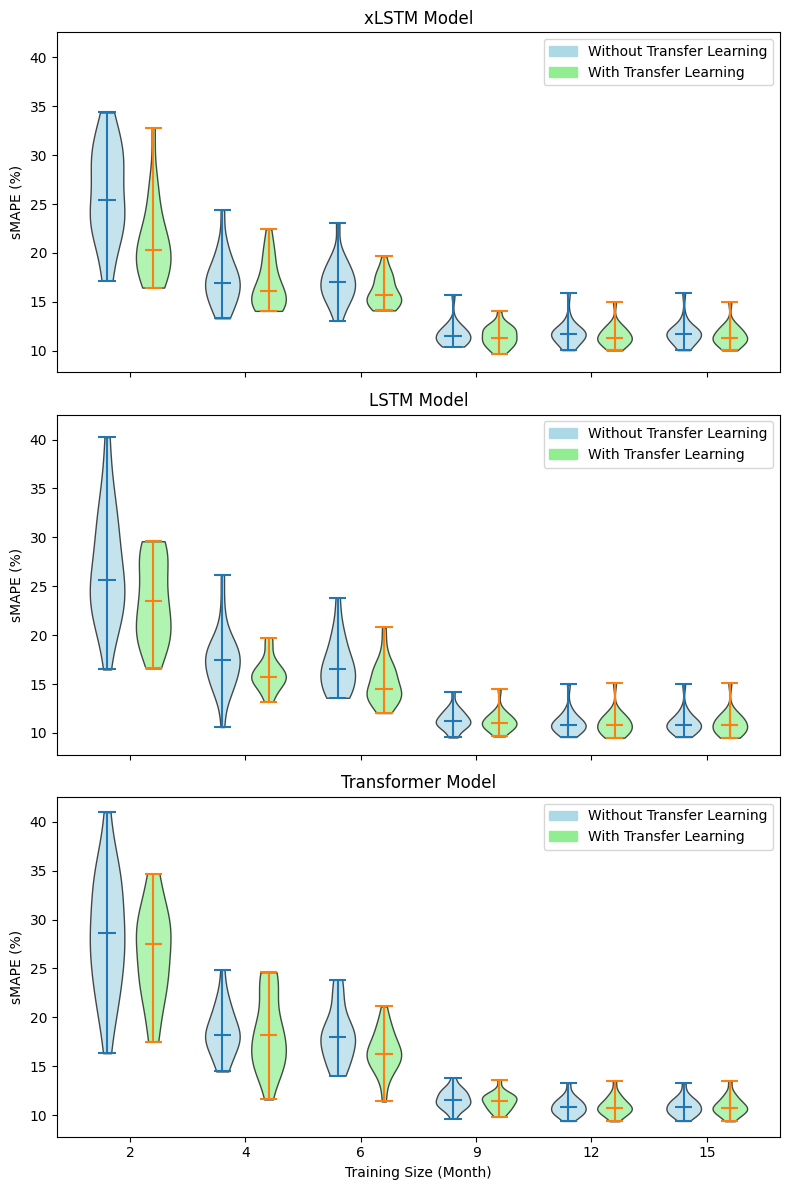

In [3]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ['xLSTM', 'LSTM', 'Transformer']
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True, sharey=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data_without = data_without_transfer[model]
    data_with = data_with_transfer[model]
    
    # Plot violin plots for without and with transfer data
    # Offset positions slightly for comparison
    positions = np.array(range(len(training_sizes))) * 2.0    
    quantiles = [[0.25, 0.75] for _ in data_with]
    
    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without, positions=positions - 0.4, widths=0.6, 
                                    showmeans=False, showextrema=True, showmedians=True)       #quantiles=quantiles
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with, positions=positions + 0.4, widths=0.6, 
                                 showmeans=False, showextrema=True, showmedians=True)

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.savefig("scripts/outputs/transfer_learning_over_train_size.pdf", format="pdf")
plt.tight_layout()
plt.show()


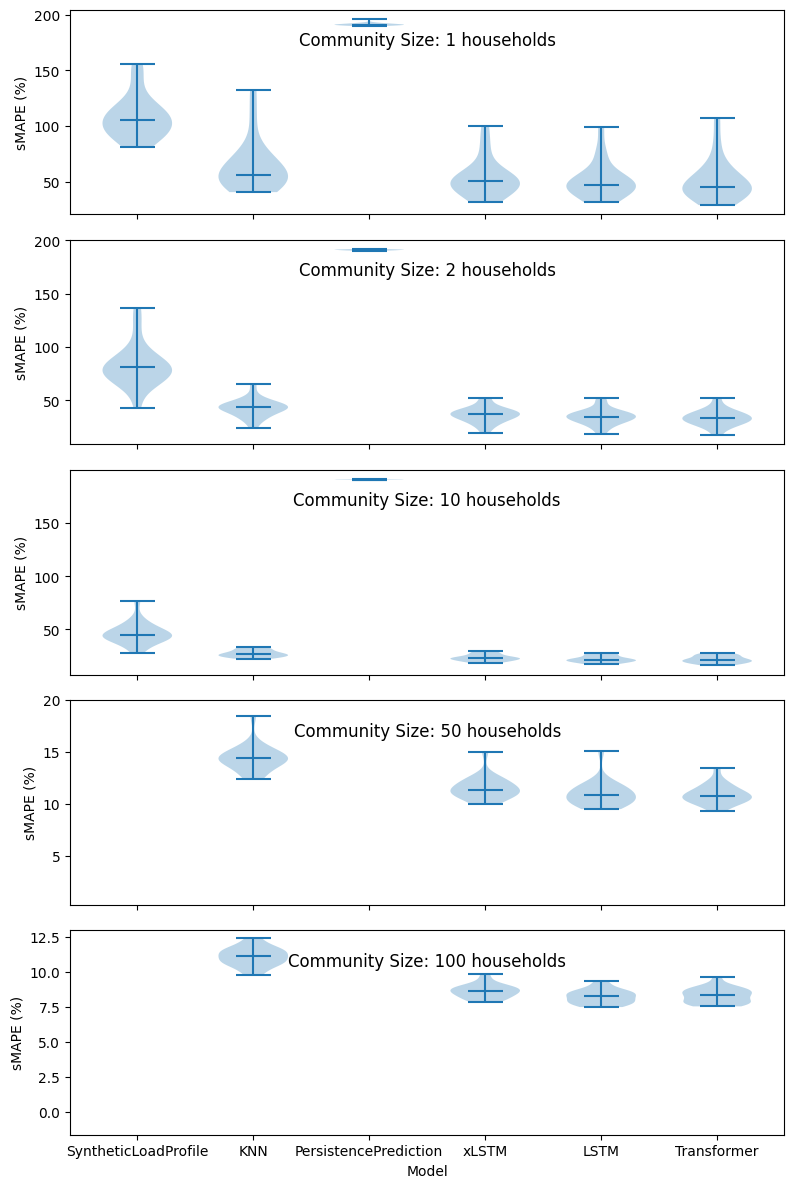

In [4]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = configs[0].usedModels
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data for each household size
data_by_household_size = {}
for i, size in enumerate(household_sizes):
    data_by_household_size[size] = [full_data_list[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(household_sizes), 1, figsize=(8, 12), sharex=True, sharey=False)

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_by_household_size.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.6, 
                            showmeans=False, showextrema=True, showmedians=True)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.text(0.5, 0.85, f"Community Size: {size} households", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    
    # Set x-axis label for the last plot
    if idx == len(household_sizes) - 1:
        ax.set_xlabel('Model')

axes[0].set_ylim(None, None)
axes[1].set_ylim(None, None)
axes[2].set_ylim(None, None)
axes[3].set_ylim(None, 20)
axes[4].set_ylim(None, 13)
plt.tight_layout()
plt.savefig("scripts/outputs/error_over_community_size.pdf", format="pdf")
plt.show()


In [2]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories_20241113_2058.pkl', 
                                    print_style = 'pandas_df')

printed_configs = [

    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the input history size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._6_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._20_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    
    # Without transfer learning:
    #
    
    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the input history size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._6_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._20_DAYS, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
config_names = ['Small', 'Medium (Baseline)', 'Large', 
                '1', '2', '10', '50 (Baseline)', '100',
                '2 mo', '6 mo', '12 mo', '15 mo (Baseline)',
                '2 days (Baseline)', '7 days', '21 days',
                ]
config_groups = [('Model Size', 3), '-', '-', 
                ('Aggregation', 4), '-', '-', '-', '-',
                ('Training Size', 4), '-', '-', '-',
                ('Input Seq Length', 3), '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
configs_without_transfer_learning = printed_configs[len(config_names):]

assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning) == len(configs_without_transfer_learning), \
        f"Unexpected list length: {len(configs)} != {len(config_names)} != {len(configs_with_transfer_learning)} != {len(configs_without_transfer_learning)}"

def print_latex_string(configs):
        latex_string = ''
        for i, expected_config in enumerate(configs):
                expected_config_found = False
                if config_groups[i] != '-':
                        latex_string += '\\hline\n'
                        latex_string += f'\\multirow{{{config_groups[i][1]}}}{{*}}{{\\textbf{{{config_groups[i][0]}}}}} \n'
                latex_string += f'    & {config_names[i]}'
                for available_config in result_dict:
                        if expected_config == available_config:
                                expected_config_found = True
                                for model_type, test_sMAPE in result_dict[available_config].items():
                                        decimal_points = 2
                                        median_test_sMAPE = f'{np.median(test_sMAPE):.{decimal_points}f}'
                                        siqr_test_sMAPE = f'{(np.percentile(test_sMAPE,75)-np.percentile(test_sMAPE,25))/2.0:.{decimal_points}f}'
                                        latex_string += f' & {median_test_sMAPE} ({siqr_test_sMAPE})'
                                latex_string += ' \\\ \n'
                if expected_config_found == False:
                        # expected config wasn't found in the test run file
                        latex_string += ' & - & - & - & - & - & - \\\ \n'
        print(latex_string)

print_latex_string(configs_with_transfer_learning)
print_latex_string(configs_without_transfer_learning)


\hline
\multirow{3}{*}{\textbf{Model Size}} 
    & Small & 27.36 (1.32) & 14.41 (0.45) & 189.95 (0.06) & 11.35 (0.51) & 10.65 (0.62) & 10.79 (0.59) \\ 
    & Medium (Baseline) & 27.36 (1.32) & 14.41 (0.45) & 189.95 (0.06) & 11.30 (0.49) & 10.84 (0.64) & 10.76 (0.57) \\ 
    & Large & 27.36 (1.32) & 14.41 (0.45) & 189.95 (0.06) & 11.80 (0.56) & 10.88 (0.64) & 10.70 (0.60) \\ 
\hline
\multirow{4}{*}{\textbf{Aggregation}} 
    & 1 & 105.13 (10.80) & 55.63 (9.71) & 190.98 (0.45) & 50.37 (7.43) & 46.74 (6.00) & 45.25 (7.46) \\ 
    & 2 & 81.01 (6.78) & 43.79 (3.49) & 191.03 (0.35) & 36.88 (3.56) & 34.12 (3.66) & 33.10 (4.23) \\ 
    & 10 & 44.36 (4.51) & 26.76 (2.37) & 190.47 (0.13) & 23.02 (2.09) & 21.71 (2.31) & 21.34 (3.01) \\ 
    & 50 (Baseline) & 27.36 (1.32) & 14.41 (0.45) & 189.95 (0.06) & 11.30 (0.49) & 10.84 (0.64) & 10.76 (0.57) \\ 
    & 100 & 25.35 (1.05) & 11.12 (0.43) & 189.82 (0.05) & 8.67 (0.29) & 8.25 (0.38) & 8.35 (0.48) \\ 
\hline
\multirow{4}{*}{\textbf{Training Size}} 

In [ ]:
# Calendar Plot part #1
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Get specific results
#
path_to_trained_parameters = 'scripts/outputs/all_trained_models_20241113_2058.pth'
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'xLSTM'

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps,
                        train_size = myConfig.trainingHistory,
                        test_size = modelTrainer.test_set_size_days,
                        prediction_history = myConfig.modelInputHistory,
                        )

smape_values = None
for community_id in range(Simulation_config.NrOfComunities._20):
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    num_of_features = X['test'].shape[2]
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).squeeze()
    Y_real = modelAdapter.deNormalizeY(Y['test']).squeeze()
    smape = my_Model.smape(Y_pred, Y_real, dim=1).unsqueeze(0)
    if smape_values == None:
        smape_values = torch.zeros((0, Y_pred.shape[0]))
    smape_values = torch.cat([smape_values, smape], dim=0)    
    
startdate = modelAdapter.getStartDateFromIndex('test', 0)
print(smape_values.shape)
print(startdate)


torch.Size([20, 131])
2013-10-20 00:00:00+00:00


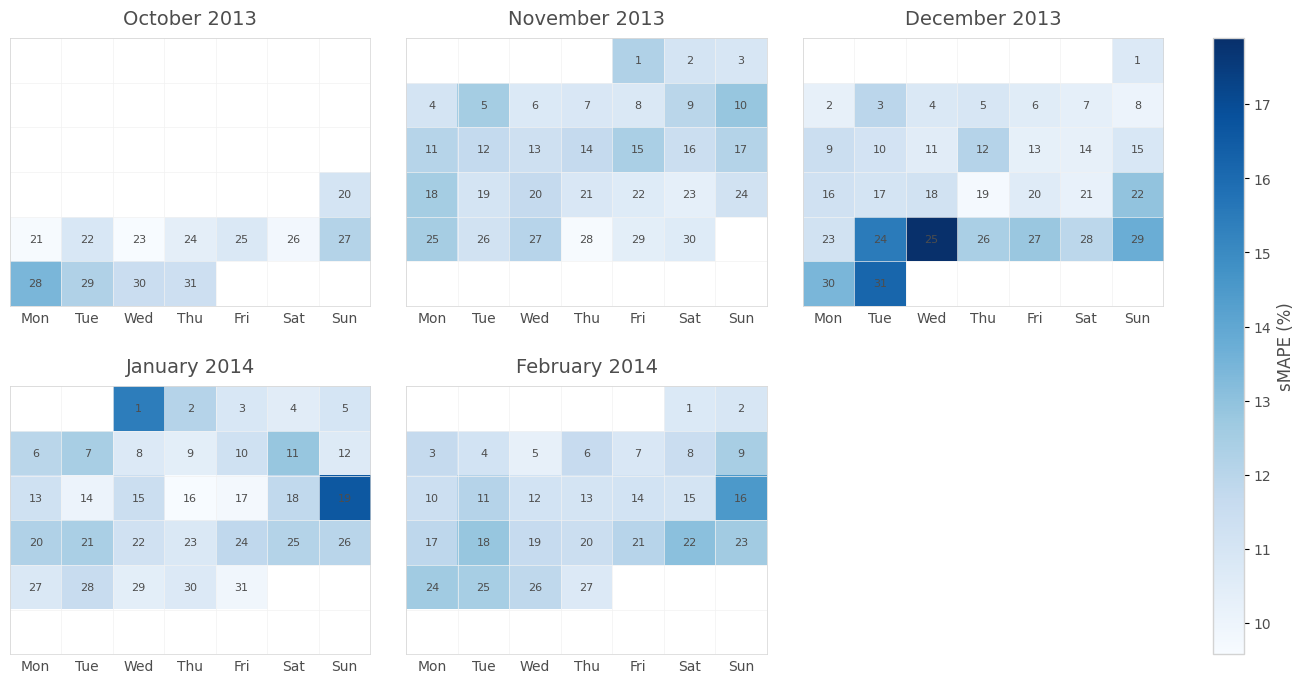

In [ ]:
# Calendar Plot part #2 
#

# Create a DataFrame for daily data
values = smape_values.mean(dim=0)
dates = pd.date_range(start=startdate, periods=len(values), freq='D')
daily_df = pd.DataFrame({'date': dates, 'value': values})

# Add additional columns for year, month, day, and weekday
daily_df['year'] = daily_df['date'].dt.year
daily_df['month'] = daily_df['date'].dt.month
daily_df['day'] = daily_df['date'].dt.day
daily_df['weekday'] = daily_df['date'].dt.weekday  # Monday = 0, Sunday = 6

# Get unique years and months in the data
years = daily_df['year'].unique()
months = daily_df['month'].unique()
num_months = len(months)

# Determine the grid size dynamically based on the number of months
rows = (num_months + 2) // 3  # Arrange in 3 columns

# Set up the figure and axis grid for the required months
fig, axs = plt.subplots(rows, 3, figsize=(16, rows * 4), constrained_layout=False)

# Adjust the spacing between rows and columns
plt.subplots_adjust(hspace=0.3, wspace=0.1)  # Increase `hspace` for more row space, `wspace` for more column space

# Use the "Blues" color map for light blue tones
cmap = plt.cm.Blues
norm = mcolors.Normalize(vmin=daily_df['value'].min(), vmax=daily_df['value'].max())

# Flatten the axis array for easy iteration, considering any unused subplots
axs = axs.flatten()

# Iterate through each unique month and year in the data
plot_idx = 0
for year in sorted(years):
    for month in range(1, 13):
        monthly_data = daily_df[(daily_df['year'] == year) & (daily_df['month'] == month)]
        if monthly_data.empty:
            continue  # Skip months with no data

        # For the first month with data, set up the start day and row appropriately
        if month == daily_df['month'].iloc[0] and year == daily_df['year'].iloc[0]:
            start_day = monthly_data['weekday'].iloc[0]  # Weekday of October 20
            starting_day_in_month = monthly_data['day'].iloc[0]  # October 20
            start_row = (start_day + starting_day_in_month - 1) // 7  # Calculate starting row
        else:
            start_day = calendar.monthrange(year, month)[0]  # First weekday of the month (0=Monday)
            starting_day_in_month = 1  # Start from the first day for subsequent months
            start_row = 0  # Start at the top row for full months

        days_in_month = calendar.monthrange(year, month)[1]  # Number of days in the month

        # Create a grid for each month, initializing empty cells with NaN for alignment
        month_matrix = np.full((6, 7), np.nan)  # Max of 6 weeks per month, 7 days per week

        # Fill in day values in the grid, starting from the appropriate row and day in the first month
        day = starting_day_in_month
        for day_idx in range(start_day, start_day + days_in_month):
            row = start_row + (day_idx // 7)
            col = day_idx % 7
            day_value = monthly_data[monthly_data['day'] == day]['value'].values
            if day_value.size > 0:
                month_matrix[row, col] = day_value[0]
            day += 1

        # Get the subplot axis for the current month
        ax = axs[plot_idx]
        plot_idx += 1
        ax.set_title(f"{calendar.month_name[month]} {year}", fontsize=14, pad=10, color="0.3")

        # Set light grey borders around each monthly subplot
        for spine in ax.spines.values():
            spine.set_edgecolor("lightgrey")
            spine.set_linewidth(0.5)

        # Display the month data as a heatmap, with NaNs handled automatically
        cax = ax.imshow(month_matrix, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")

        # Annotate each cell with the day number, starting from the correct day in the first month
        day = starting_day_in_month
        for week in range(6):  # 6 rows (weeks) per month
            for weekday in range(7):  # 7 columns (days)
                if not np.isnan(month_matrix[week, weekday]):
                    ax.text(weekday, week, str(day), ha='center', va='center', fontsize=8, color="0.3")
                    day += 1  # Move to the next day in the month

        # Set x-axis and y-axis ticks to align the grid with daily boxes
        ax.set_xticks(np.arange(-0.5, 7, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 6, 1), minor=True)
        ax.grid(which="minor", color="0.95", linestyle='-', linewidth=0.5)  # Grid around each daily box

        # Keep weekday labels but remove small ticks on x and y axes
        ax.tick_params(axis="both", which="both", length=0)

        # Set x-axis labels for weekdays
        ax.set_xticks(range(7))
        ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], fontsize=10, color="0.3")
        ax.set_yticks([])

# Add a color bar for the legend
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label("sMAPE (%)", fontsize=12, color="0.3")
cbar.outline.set_edgecolor(color="lightgrey")
cbar.outline.set_linewidth(1)
cbar.ax.yaxis.set_tick_params(labelcolor="0.3")

# Hide any unused subplots
for i in range(plot_idx, len(axs)):
    fig.delaxes(axs[i])

plt.show()
